In [1]:
from activity import *
from bkps_detection import *
from random_walk import *
from pathlib import Path

# Analysis of Mouse Activity: Differentiating Behavioral Patterns via Gaussian Kernel Change Point Detection Algorithm

# Introduction

The primary objective of this notebook is to present a comprehensive analysis of mouse activity via Gaussian kernel change point detection algorithm.

For a given signal $y = \{y_t\}^T_{t=1}$, the $(b-a)$-sample long sub-signal $\{y_t\}^b_{t=a+1} (1 \leq a < b \leq T)$ is simply denoted $y_{a.b}$. A set of indexes is denoted by a calligraphic letter: $\mathcal{T} = \{t_1 , . . ., t_K \} \subset \{1, . . . , T \}$. 

Formally, change point detection is cast as a model selection problem, which consists in choosing the best possible segmentation $\mathcal{T}$ according to a quantitative criterion $\mathcal{V}(\mathcal{T})$ that must be minimized. We make the assumption that for a signal $y$ the criterion function $\mathcal{V}(\mathcal{T})$ for a particular segmentation is a sum of costs of all the segments that define the segmentation:
\begin{equation}
    \mathcal{V}(\mathcal{T})\colon= \sum_{k=0}^{K} c(y_{t_k.t_{k+1}}) 
\end{equation}
where $c(\cdot)$ is a cost function which measures goodness-of-fit of the sub-signal $y_{t_k.t_{k+1}}$ to a specific model. The "best segmentation" $\widehat{\mathcal{T}}$ is the minimizer of the criterion $\mathcal{V}(\mathcal{T})$.


When the number of changes is unknown, which is the case here, the change point detection problem consists in solving the following discrete optimization problem $\min_{\mathcal{T}} \mathcal{V}(\mathcal{T}) + pen(\mathcal{T})$
where $pen(\mathcal{T})$ is an appropriate measure of the complexity of a segmentation $\mathcal{T}$.

To perform change-point detection in a non-parametric setting, kernel-based methods map the original signal $y$ onto a reproducing kernel Hilbert space $\mathcal{H}$ (rkhs) associated with a user-defined kernel function $k(\cdot,\cdot)\colon\mathbb{R}^d\times\mathbb{R}^d\longrightarrow\mathbb{R}$.\\
The mapping function $\phi\colon\mathbb{R}^d\longrightarrow\mathcal{H}$ onto this rkhs is implicitly defined by $\phi(y_t) = k(yt,\cdot) \in\mathcal{H}$, resulting in the following inner product and norm: $\langle\phi(y_s) \vert \phi(y_t)\rangle_\mathcal{H} = k(y_s,y_t) \quad \textrm{and} \quad \Vert\phi(y_t) \Vert^2_\mathcal{H} = k(y_t,y_t)$ for any samples $y_s, y_t \in \mathbb{R}^d$.

For a kernel-based change point detection algorithm, the associated cost function, denoted $c_{kernel}$ , is defined as follows: 

\begin{equation}
    c_{kernel}(y_{a.b}) \colon= \sum_{t=a+1}^{b} \Vert \phi(y_t) - \overline\mu_{a.b} \Vert^2_\mathcal{H}
\end{equation}
where $\overline\mu_{a.b}\in\mathcal{H}$ is the empirical mean of the embedded signal
$\{\phi(y_t)\}_{t=a+1}^{b}$.


The Gaussian (or radian basis function) kernel $k$ is defined by $k(x,y) = exp(- \gamma  \Vert x - y \Vert^2)$, with $x, y \in \mathbb{R}^d$ and $\gamma > 0$ the so-called bandwidth parameter. 

# Analysis

### Data processing

Usefull functions to process the data

In [2]:
def split_array(array, indexes):
    # Splits an array into multiple sub-arrays. 
    # Each sub-array is created in such a way that the last value of each sub-array becomes the first value of the next sub-array.
    array_indexes = np.asarray(indexes)
    subarrays = []
    start = 0
    end = array.shape[0]
    array_indexes = np.append(array_indexes,end)

    for index in array_indexes:
        subarray = array[start:index+1]  
        subarrays.append(subarray)
        start = index

    return subarrays


def divide_signal(signal, time_arr):    
    # Divide the signal in hour-long sub-signals
    fs = np.round(1/np.diff(time_arr)[0], 2) # sampling frequency
    ONE_HOUR = int(fs * 3600) 

    split_indexes = []
    split_index = 0

    while split_index <= len(time_arr):
        split_indexes.append(split_index)
        split_index = split_index + ONE_HOUR
    split_indexes.sort()

    list_of_signals = split_array(signal, split_indexes)[1:-1]
    list_of_signals_time = split_array(time_arr, split_indexes)[1:-1] 

    return list_of_signals, list_of_signals_time

In order to perform a change point detection algorithm, we need to import our data and transform it into arrays. As our signals are heavy, to perform the algorithm faster we will divide them in 1-hour long sub-signals.  

In [3]:
# Path of our signal
SIGNAL_PATH8 = Path(r"C:\Users\cleme\Documents\stage2023\final_package\processed_signals\signal8.csv")

# Read the signal and transform it into arrays
dataframe8 = pd.read_csv(SIGNAL_PATH8, names=["time", "signal"], header=0)
signal8, time_arr8 = dataframe8.signal.to_numpy(), dataframe8.time.to_numpy()

# Divide the signal in hour-long sub-signals  
list_of_signals8, list_of_signals_time8 = divide_signal(signal8, time_arr8)

### Gaussian kernel change point detection

In [4]:
# Measure of the complexity of a segmentation
beta = 0.4 

# Detection
list_of_bkps_pred8 = get_list_of_bkps_pred(list_of_signals8, beta)

The result is a list of sub-lists. First elements of a sub-list are change point indexes and the last is the number of samples.

In [5]:
list_of_bkps_pred8[3]

[5511,
 8034,
 8046,
 12374,
 12401,
 14208,
 15261,
 17726,
 19424,
 21042,
 21769,
 21779,
 26475,
 30076,
 32905]

We can visualize the signal and the change points calculated previsouly in alternating colors. At each change point, the background color changes.

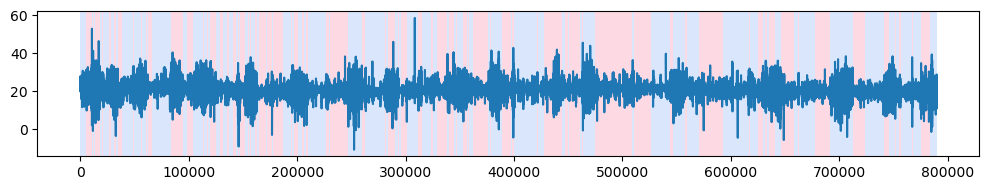

In [6]:
ONE_HOUR8 = int(np.round(1/np.diff(time_arr8)[0], 2) * 3600)

bkps_pred_all_hours8 = []
for k in range(24):
    bkps_pred_all_hours8 = bkps_pred_all_hours8 + [bkp + k*ONE_HOUR8 for bkp in list_of_bkps_pred8[k]]

fig, ax_array = rpt.display(signal8, bkps_pred_all_hours8)

### Classification

 To quantitatively describe the intensity of behavior during a given segment, we propose calculating the standard deviation of the variable $p$, noted $\sigma_p$, throughout the duration of the segment. The classification of segments as ```rest``` or ```activity``` is contingent upon whether the $\sigma_p$ value exceeds or falls below a specific threshold value.

In [7]:
# The threshold at which a segment is classified as 'activity' or 'rest'
threshold = 1.5 

# Classify the segments in two categories : activity/rest
df8 = classify_signal(list_of_signals8, list_of_signals_time8, list_of_bkps_pred8, threshold = 1.5)
df8

,hour,start_time,end_time,duration,SD_p,day_or_night,day_or_night_number,activity
0,1,27656.738710,28275.523526,618.784816,0.719205,night,0,False
1,1,28275.523526,28791.378076,515.854550,1.815115,night,0,True
2,1,28791.378076,28801.660165,10.282088,4.450177,night,0,True
3,1,28801.660165,28831.850126,30.189961,2.680715,night,0,True
4,1,28831.850126,28833.490884,1.640759,13.444278,night,0,True
...,...,...,...,...,...,...,...,...
296,24,113325.456462,113553.850080,228.393618,2.822866,day,1,True
297,24,113553.850080,113595.197201,41.347120,4.504139,day,1,True
298,24,113595.197201,113948.397867,353.200667,1.898072,day,1,True
299,24,113948.397867,113950.804313,2.406446,5.586133,day,1,True


### Visualization and features

Once the value $\sigma_p$ has been computed for each segment, we can visually assess the vigor or intensity of the mouse’s behavior. This visualization allows us to gain a qualitative understanding of the behavioral patterns exhibited.
<code style="background:red;color:darkred">activity</code> <code style="background:lightblue;color:darkblue">rest</code> 

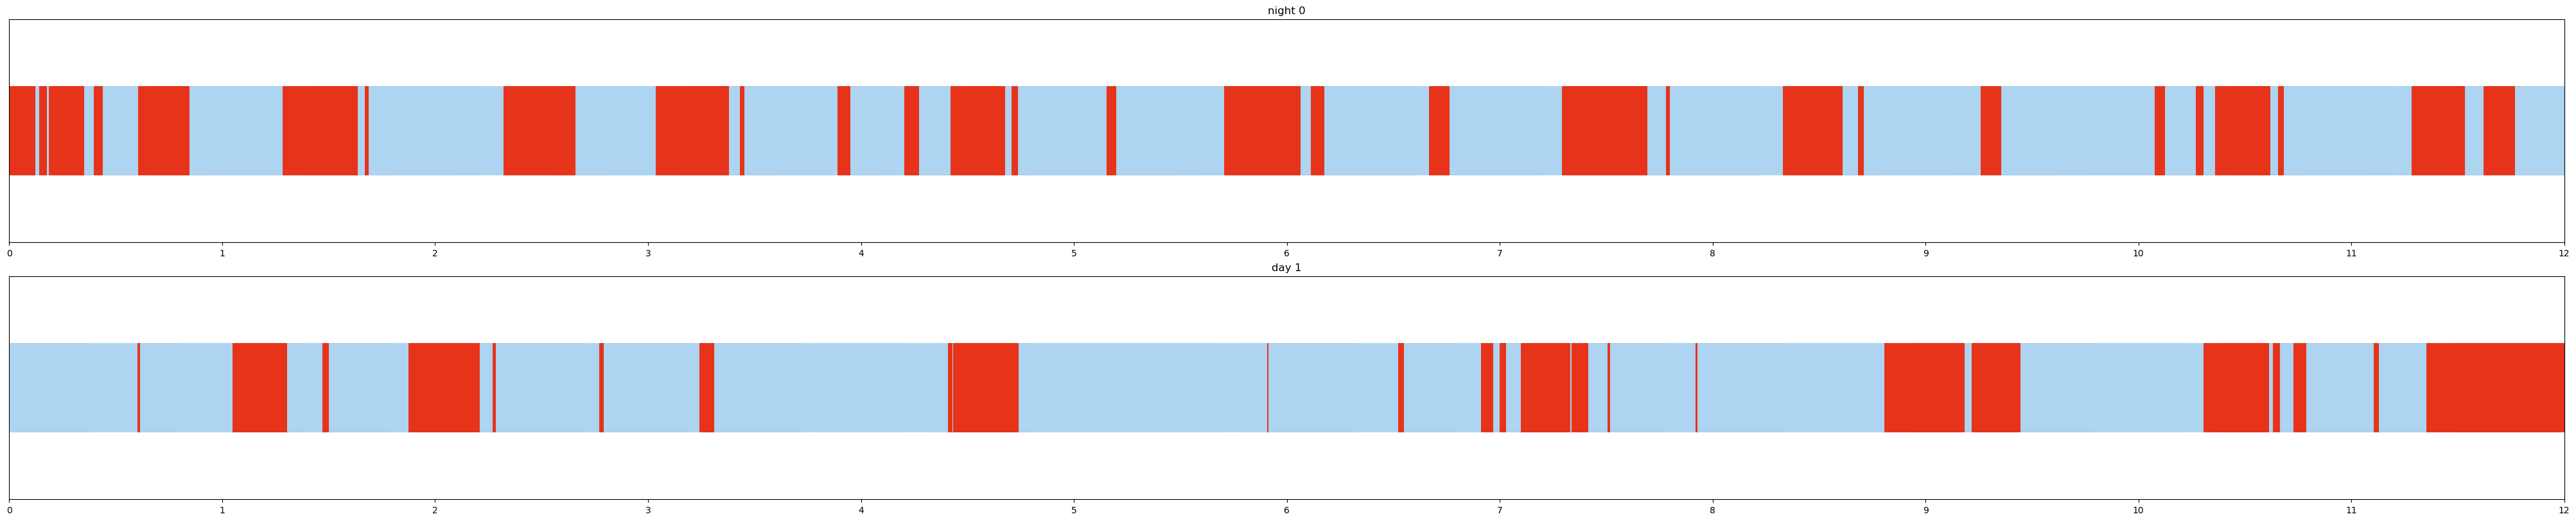

In [8]:
# Each segment is representend in yellow if 'rest' and red if 'activity'.
timeline(df8, binary = True)

The activity/rest classification depends on an arbitrary threshold that sets our degree of requirement for considering a movement as activity. 
Thus, visualizing each segment independently of its classification and solely in terms of its variability allows us to gain a qualitative understanding of the behavioral patterns exhibited. 

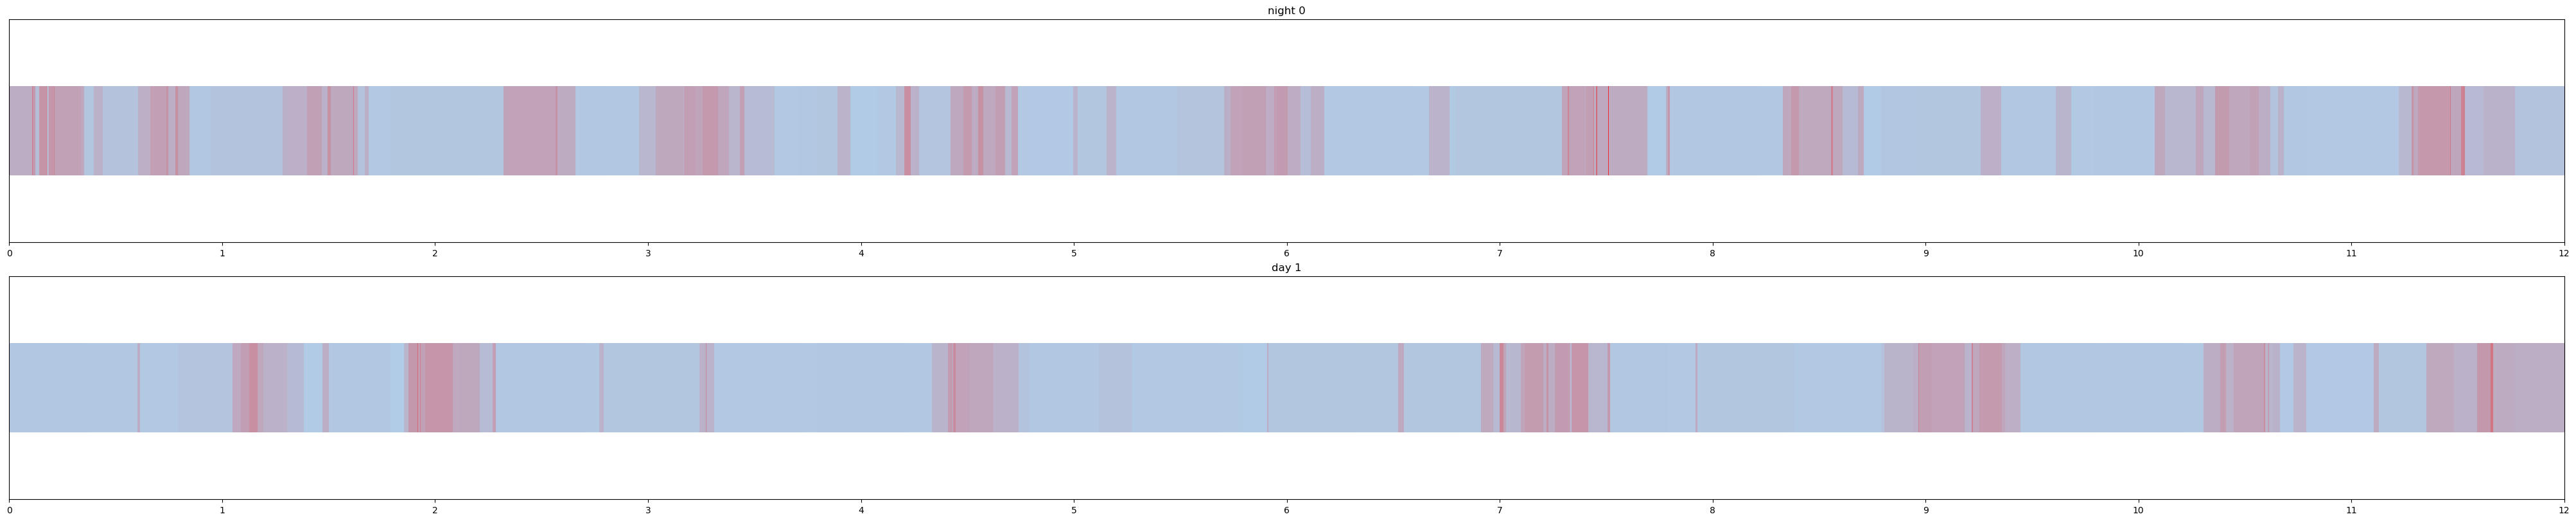

In [9]:
timeline(df8, binary = False)

To better understand the mouse's behavior, it is interesting to observe the distribution of $\sigma_p$ and calculate some features on $\sigma_p$ ...

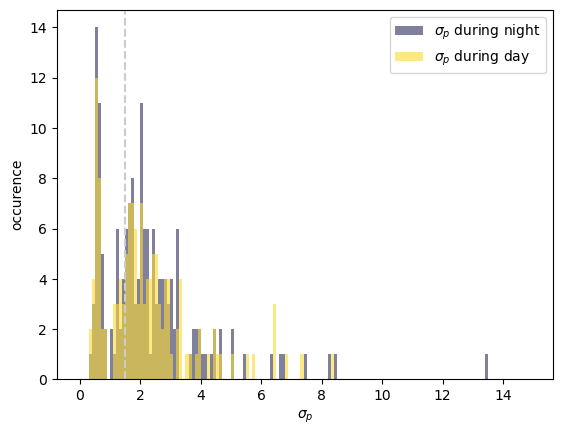

,hour,start_time,end_time,duration,SD_p,day_or_night,day_or_night_number,activity
0,1,27656.738710,28275.523526,618.784816,0.719205,night,0,False
1,1,28275.523526,28791.378076,515.854550,1.815115,night,0,True
2,1,28791.378076,28801.660165,10.282088,4.450177,night,0,True
3,1,28801.660165,28831.850126,30.189961,2.680715,night,0,True
4,1,28831.850126,28833.490884,1.640759,13.444278,night,0,True
...,...,...,...,...,...,...,...,...
296,24,113325.456462,113553.850080,228.393618,2.822866,day,1,True
297,24,113553.850080,113595.197201,41.347120,4.504139,day,1,True
298,24,113595.197201,113948.397867,353.200667,1.898072,day,1,True
299,24,113948.397867,113950.804313,2.406446,5.586133,day,1,True


In [10]:
distribution_SD(df8, threshold = 1.5)

In [11]:
# Calculate statistics for the 'SD_p' column
mean, minimum, p25, p50, p75, rMSSD = SD_features(df8)

mean  2.255938174634833 
minimum  0.3359198095601668 
25%  1.2546756136141959 
50%  2.0025708645628497 
75%  2.822866452327674 
RMSSD  2.187771850865886


... as well as temporal features on the duration of behaviours.

In [12]:
# Calculates temporal features
sum_duration_list8, avg_sum_1_list8, avg_sum_1_list_pourcentage8, avg_segment_duration_list8 = activity_rest_features(df8)

duration activity day  10945.610993201539  - duration rest day  32244.300303669108  - duration activity night  15460.103996933281  - duration rest night  27729.916683853917  - duration activity day  10945.610993201539

 avg duration activty day  10945.610993201539  ( 25.3 %)  - avg duration rest day  32244.300303669108  ( 74.6 %)  - avg duration activty night  15460.103996933283  ( 35.8 %)  - avg duration rest night  27729.916683853913  ( 64.2 %)

 avg segment activty day  115.2169578231741  - avg segment rest day  749.8674489225374  - avg segment activty night  138.03664282976143  - avg segment rest night  27729.916683853913


### Random Walk

Another way of analyzing mouse behavior is to model our signal as a random walk. We create a time series starting at 0, for each second of activity we increase by 1, for each second of rest we decrease by 1. 

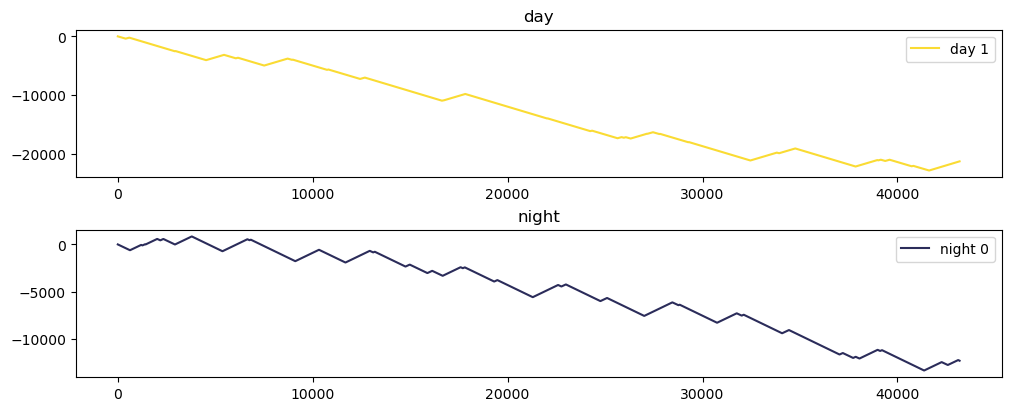

In [13]:
plot_random_walk(df8)

Long periods of activity/rest appear, interspersed with a few short periods of rest/activity. We'd like to ignore these brief changes and consider only the overall behavioral trend. To do this, we perform a linear kernel change point detection on the derivative of our random walk. 

(14139, 29050, 1285.3636363636363, 2640.909090909091, 11, 11, 1825)

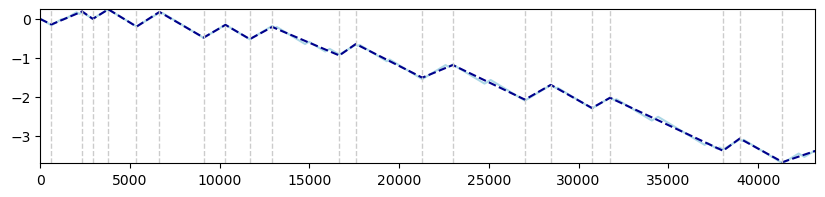

In [14]:
features_random_walk_day_night(df8, 'night', 0, plot = True)

#duration activity, duration rest, average duration activity, average duration rest, number of activity, number of rest, longest activity

We have obtained a new classification that tells us about the mouse's overall behavior over a given day/night. 

# Comparing two signals

In [15]:
# Path of our signal
SIGNAL_PATH4 = Path(r"C:\Users\cleme\Documents\stage2023\final_package\processed_signals\signal4.csv")

# Read the signal and transform it into arrays
dataframe4 = pd.read_csv(SIGNAL_PATH4, names=["time", "signal"], header=0)
signal4, time_arr4 = dataframe4.signal.to_numpy(), dataframe4.time.to_numpy()

# Divide the signal in hour-long sub-signals  
list_of_signals4, list_of_signals_time4 = divide_signal(signal4, time_arr4)
# Measure of the complexity of a segmentation
beta4 = 0.4 

# Detection
list_of_bkps_pred4 = get_list_of_bkps_pred(list_of_signals4, beta4)

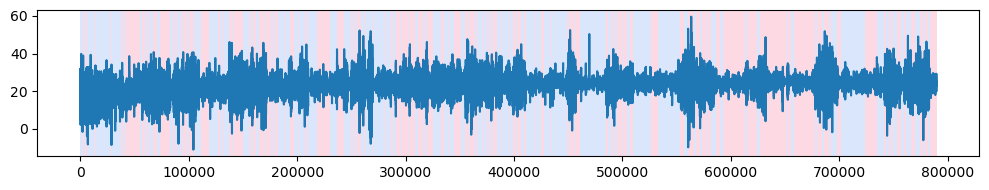

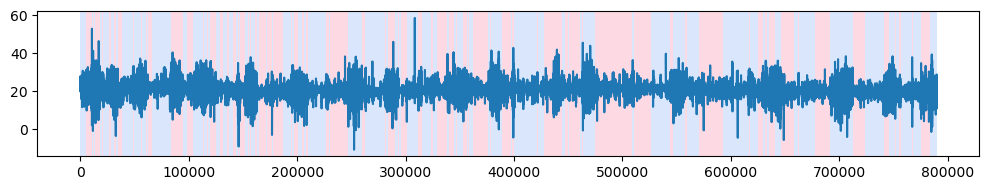

In [16]:

ONE_HOUR4 = int(np.round(1/np.diff(time_arr4)[0], 2) * 3600)
bkps_pred_all_hours4 = []
for k in range(24):
    bkps_pred_all_hours4 = bkps_pred_all_hours4 + [bkp + k*ONE_HOUR4 for bkp in list_of_bkps_pred4[k]]

fig, ax_array = rpt.display(signal4, bkps_pred_all_hours4)


ONE_HOUR8 = int(np.round(1/np.diff(time_arr4)[0], 2) * 3600)
bkps_pred_all_hours8 = []
for k in range(24):
    bkps_pred_all_hours8 = bkps_pred_all_hours8 + [bkp + k*ONE_HOUR8 for bkp in list_of_bkps_pred8[k]]

fig, ax_array = rpt.display(signal8, bkps_pred_all_hours8)


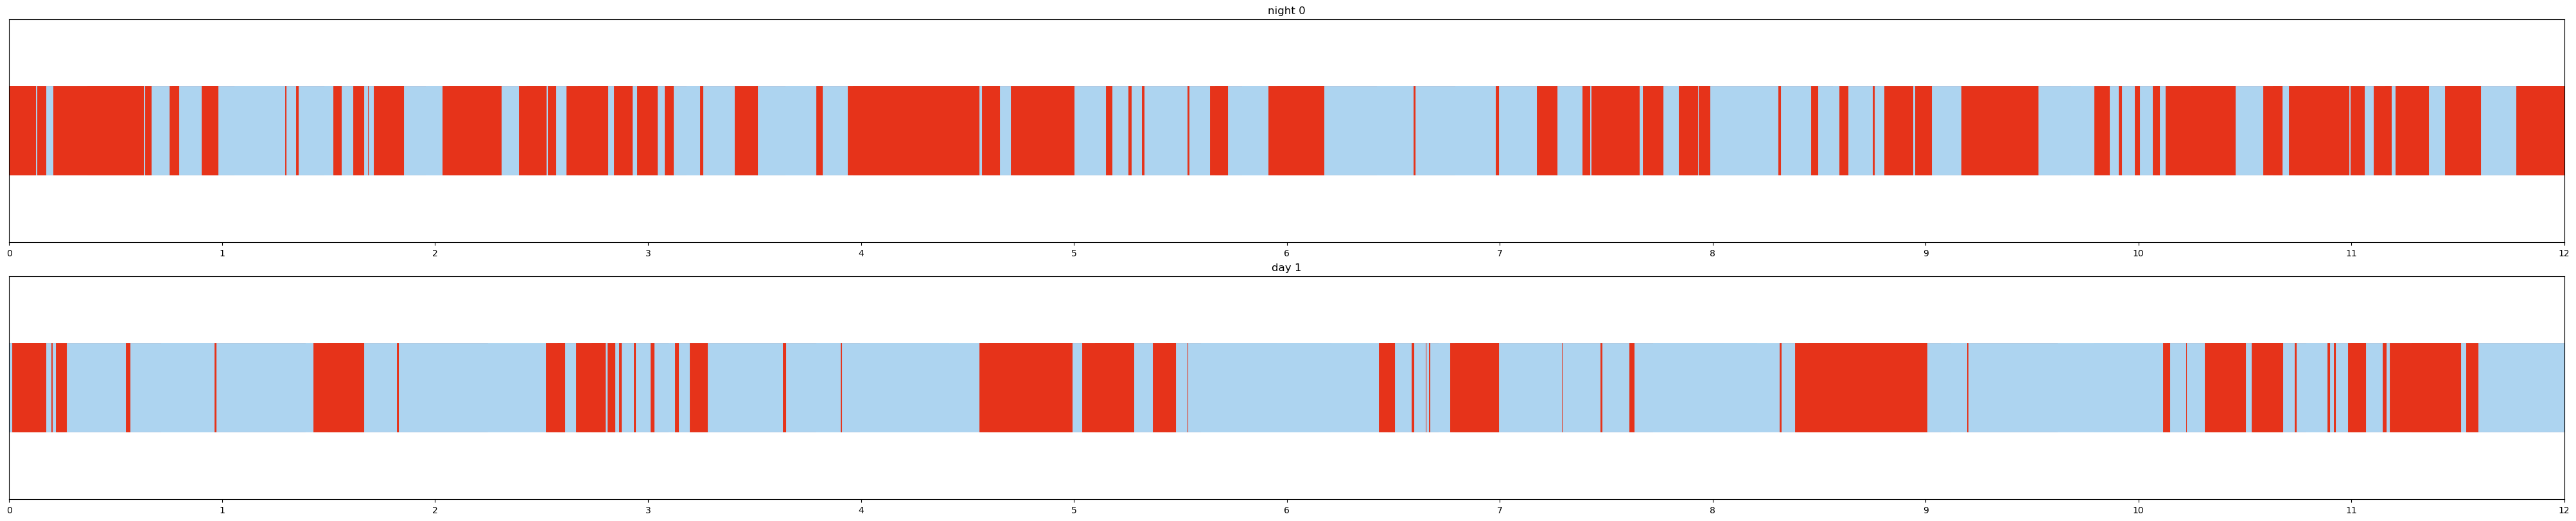

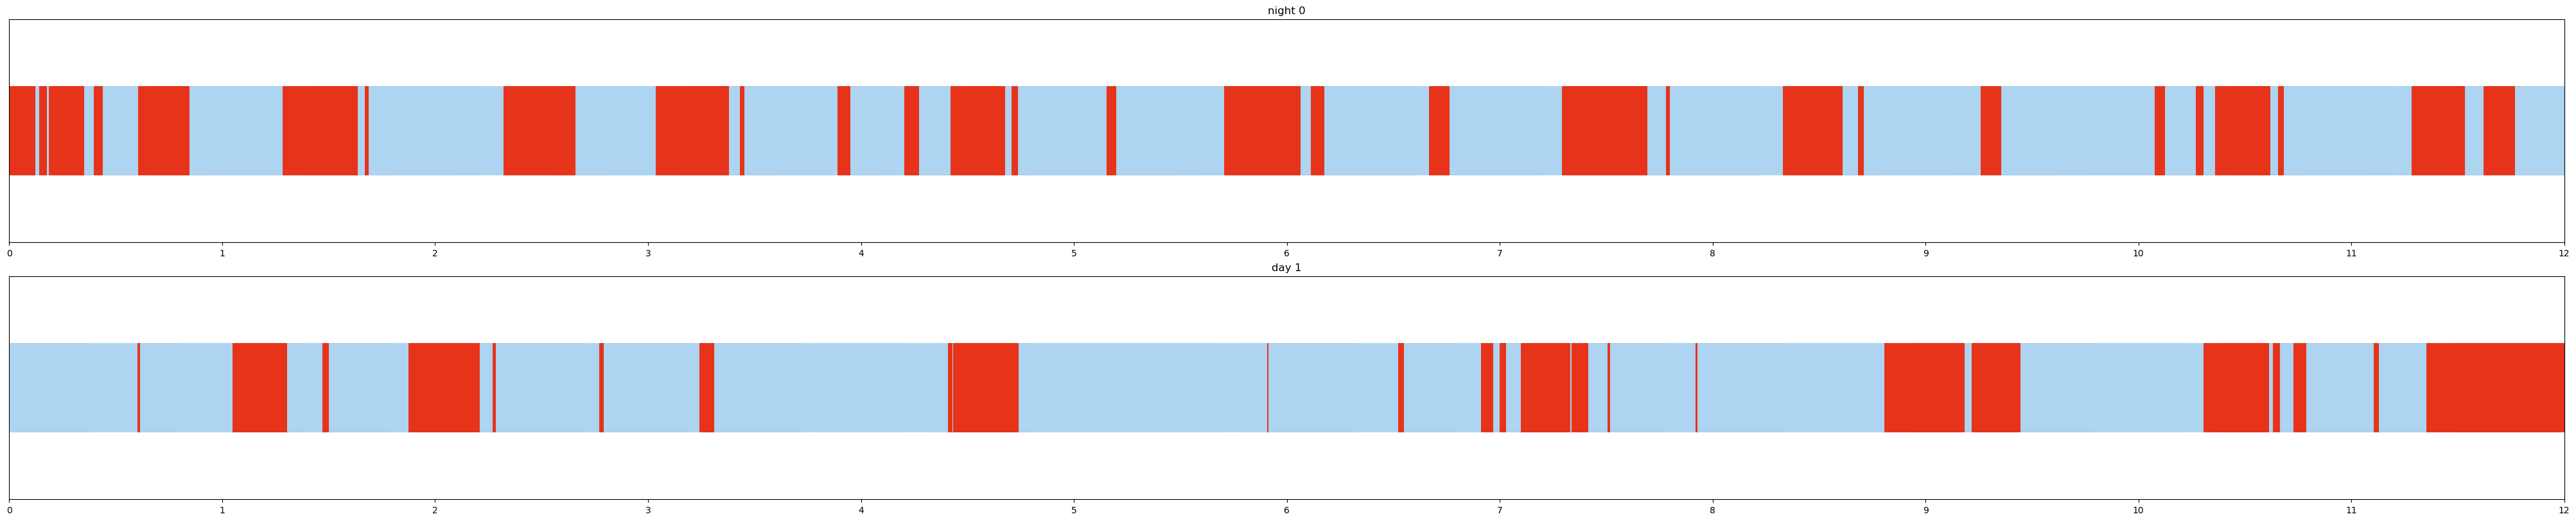

In [17]:
# The threshold at which a segment is classified as 'activity' or 'rest'
threshold = 1.5 

# Classify the segments in two categories : activity/rest
df4 = classify_signal(list_of_signals4, list_of_signals_time4, list_of_bkps_pred4, threshold = 1.5)
df8 = classify_signal(list_of_signals8, list_of_signals_time8, list_of_bkps_pred8, threshold = 1.5)

# Each segment is representend in yellow if 'rest' and red if 'activity'.
timeline(df4, binary = True)
timeline(df8, binary = True)

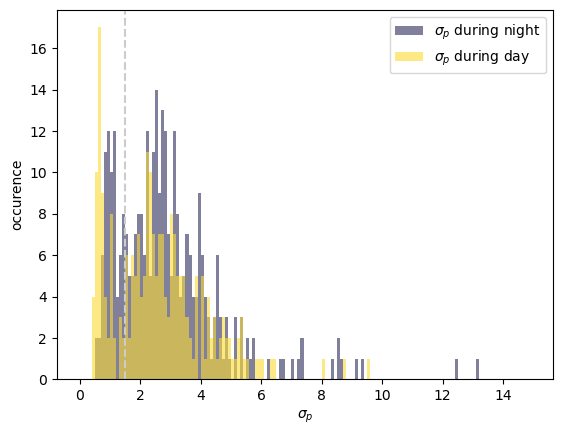

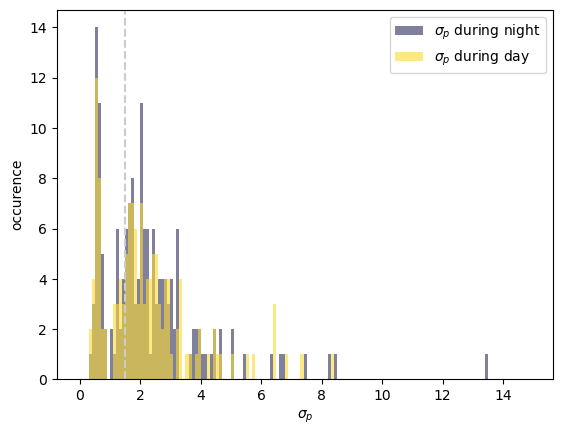

,hour,start_time,end_time,duration,SD_p,day_or_night,day_or_night_number,activity
0,1,27656.738710,28275.523526,618.784816,0.719205,night,0,False
1,1,28275.523526,28791.378076,515.854550,1.815115,night,0,True
2,1,28791.378076,28801.660165,10.282088,4.450177,night,0,True
3,1,28801.660165,28831.850126,30.189961,2.680715,night,0,True
4,1,28831.850126,28833.490884,1.640759,13.444278,night,0,True
...,...,...,...,...,...,...,...,...
296,24,113325.456462,113553.850080,228.393618,2.822866,day,1,True
297,24,113553.850080,113595.197201,41.347120,4.504139,day,1,True
298,24,113595.197201,113948.397867,353.200667,1.898072,day,1,True
299,24,113948.397867,113950.804313,2.406446,5.586133,day,1,True


In [18]:
distribution_SD(df4)
distribution_SD(df8)

In [19]:
# Calculate statistics for the 'SD_p' column
mean4, minimum4, p25_4, p50_4, p75_4, rMSSD4 = SD_features(df4)
mean8, minimum8, p25_8, p50_8, p75_8, rMSSD8 = SD_features(df8)

mean  2.746380720398441 
minimum  0.4550982384293304 
25%  1.5228667671964962 
50%  2.552664703792348 
75%  3.505354878882673 
RMSSD  2.1975767005566103
mean  2.255938174634833 
minimum  0.3359198095601668 
25%  1.2546756136141959 
50%  2.0025708645628497 
75%  2.822866452327674 
RMSSD  2.187771850865886


In [20]:
# Calculates temporal features
sum_duration_list4, avg_sum_1_list4, avg_sum_1_list_pourcentage4, avg_segment_duration_list4 = activity_rest_features(df4)
sum_duration_list8, avg_sum_1_list8, avg_sum_1_list_pourcentage8, avg_segment_duration_list8 = activity_rest_features(df8)

duration activity day  13344.203025930648  - duration rest day  29845.423861889416  - duration activity night  22604.80318643981  - duration rest night  20584.933084576496  - duration activity day  13344.203025930648

 avg duration activty day  13344.203025930648  ( 30.9 %)  - avg duration rest day  29845.423861889416  ( 69.1 %)  - avg duration activty night  22604.80318643981  ( 52.3 %)  - avg duration rest night  20584.933084576496  ( 47.7 %)

 avg segment activty day  77.58257573215494  - avg segment rest day  489.2692436375314  - avg segment activty night  90.41921274575924  - avg segment rest night  20584.933084576496
duration activity day  10945.610993201539  - duration rest day  32244.300303669108  - duration activity night  15460.103996933281  - duration rest night  27729.916683853917  - duration activity day  10945.610993201539

 avg duration activty day  10945.610993201539  ( 25.3 %)  - avg duration rest day  32244.300303669108  ( 74.6 %)  - avg duration activty night  15460.

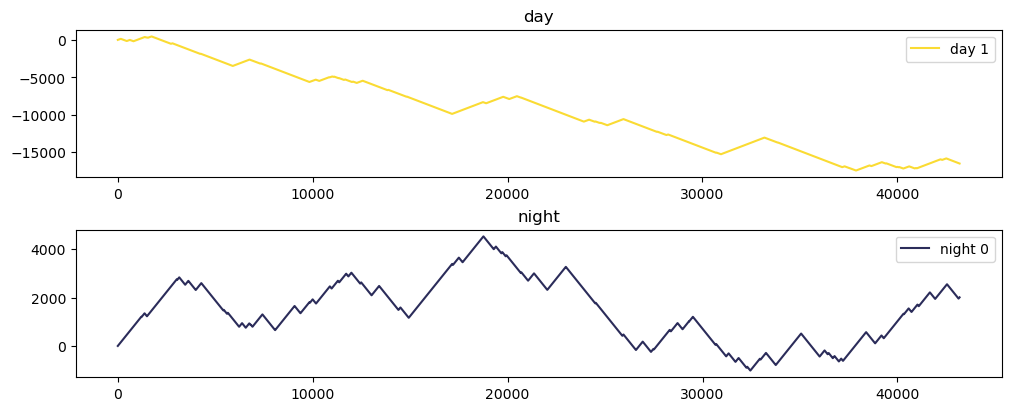

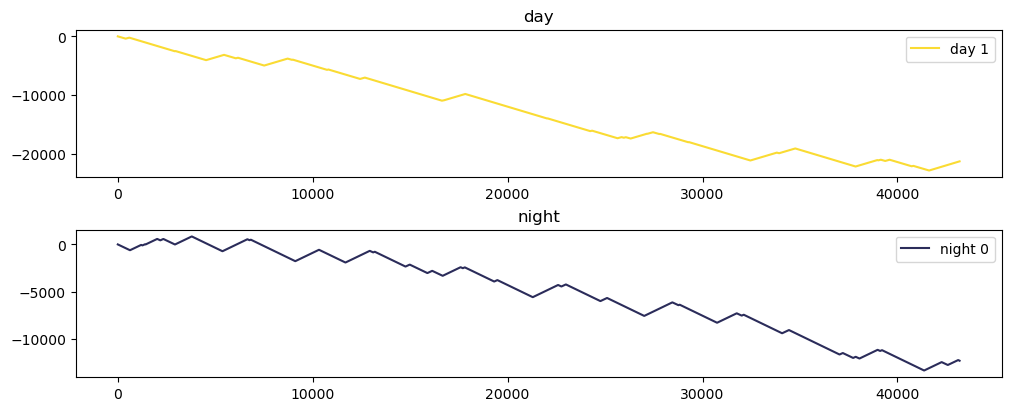

In [21]:
plot_random_walk(df4)
plot_random_walk(df8)

(14139, 29050, 1285.3636363636363, 2640.909090909091, 11, 11, 1825)

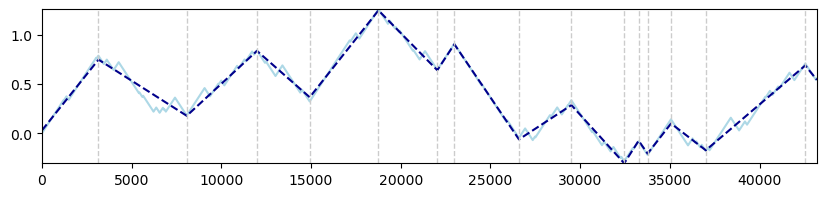

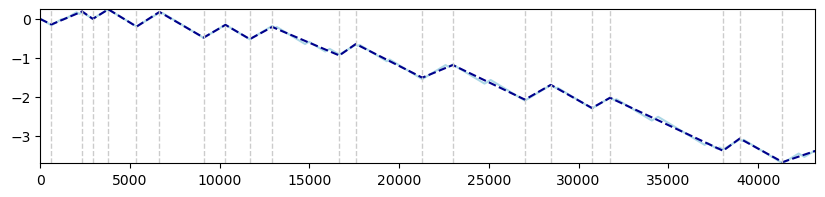

In [22]:

features_random_walk_day_night(df4, 'night', 0, plot = True)
features_random_walk_day_night(df8, 'night', 0, plot = True)

# Robustness of penalty

In the previous section, we haven't discussed the penalty. 
The more popular choice of penalty is the linear penalty, which is given by $pen(\mathcal{T}) = \beta\cdot\log(T)\cdot\vert \mathcal{T} \vert$ where $\beta > 0$ is the smoothing parameter. \
The value of $\beta$ we've used previsously is $\beta = 0.4$. Let's justify this value.

We perform the change point detection algorithm on a same signal for different values of $\beta$.

In [23]:
#Calculating the number of bkps, for n values of Beta in [0.01, 1]

n_beta = 7
penalties = [0.01 + k*(1-0.01)/(n_beta-1) for k in range(n_beta)]
n_bkps_beta = []
activity_time = []
list_list_of_bkps_pred = []

for beta in penalties:
    list_of_bkps_pred = get_list_of_bkps_pred(list_of_signals8, beta)
    list_list_of_bkps_pred.append(list_of_bkps_pred)

    df = classify_signal(list_of_signals8, list_of_signals_time8, list_of_bkps_pred)

    n_bkps_beta.append(len(df))

    false_day_sum = df.loc[(df['activity'] == False) & (df['day_or_night'] == 'day'), 'duration'].sum()
    true_day_sum = df.loc[(df['activity'] == True) & (df['day_or_night'] == 'day'), 'duration'].sum()
    false_night_sum = df.loc[(df['activity'] == False) & (df['day_or_night'] == 'night'), 'duration'].sum()
    true_night_sum = df.loc[(df['activity'] == True) & (df['day_or_night'] == 'night'), 'duration'].sum()

    activity_time.append([false_day_sum, true_day_sum, false_night_sum, true_night_sum])

We compare the duration of activity and rest for each value of $\beta$...

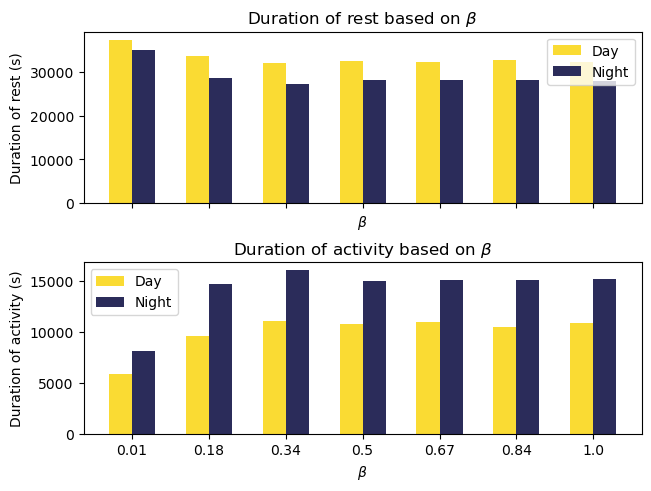

In [ ]:
#Duration of activity and rest based on beta 

fig, [ax1, ax2] = plt.subplots(2, 1, layout='constrained', sharex=True)

width = 0.3

# Calculate the x positions of the bars
x = np.arange(n_beta)

ax1.bar(x, np.asarray(activity_time)[:,0], width, label='Day', color='#FADB33')
ax1.bar(x + width, np.asarray(activity_time)[:,2], width, label='Night', color='#2B2C5A')

# Set plot properties
ax1.set_xlabel(r'$ \beta $')
ax1.set_ylabel('Duration of rest (s)')
ax1.set_title('Duration of rest based on $ \\beta $')
ax1.set_xticks(x + width / 2)
ax1.set_xticklabels(np.round(np.asarray(penalties), 2))
ax1.legend()

ax2.bar(x, np.asarray(activity_time)[:,1], width, label='Day', color='#FADB33')
ax2.bar(x + width, np.asarray(activity_time)[:,3], width, label='Night', color='#2B2C5A')

# Set plot properties
ax2.set_xlabel(r'$ \beta $')
ax2.set_ylabel('Duration of activity (s)')
ax2.set_title('Duration of activity based on $ \\beta $')
ax2.set_xticks(x + width / 2)
ax2.set_xticklabels(np.round(np.asarray(penalties), 2))
ax2.legend()


plt.show()

... as well as the number of change points detected.

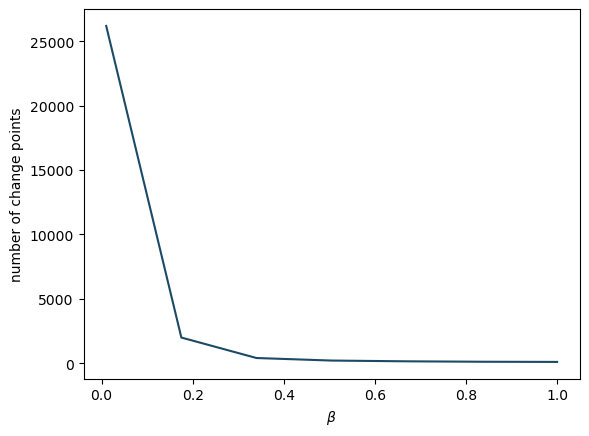

In [ ]:
#number of bkps based on beta

plt.plot(penalties, n_bkps_beta, color='#1C4966')
plt.xlabel(r'$ \beta $')
plt.ylabel('number of change points')

plt.show()


When computing the Rand Index between two predicted segmentations, which measures the average similarity between two predicted segmentations, we observe a favorable level of concordance among all the predictions. The Rand Index is standardized between 0 (complete dissimilarity) and 1 (complete agreement). 

In [ ]:
list_list_of_bkps_pred_RI = [[[5657, 6578, 6588, 6635, 6645, 7158, 8767, 8818, 9419, 9443, 10373, 10387, 10397, 10412, 10425, 10440, 10451, 10743, 10759, 10796, 10845, 10899, 11492, 11561, 11580, 11614, 11681, 11702, 11806, 11820, 11831, 11880, 11958, 11975, 11991, 12021, 12203, 12214, 12343, 12361, 12434, 12444, 12588, 12674, 12684, 12965, 13130, 13186, 13223, 13313, 13341, 13357, 13419, 13437, 13447, 13502, 13551, 13708, 13718, 13776, 13787, 13818, 13830, 13845, 14104, 14117, 14316, 14327, 14337, 14402, 14533, 14543, 14606, 14654, 14666, 14715, 14728, 14741, 15007, 15022, 15104, 15127, 15258, 15541, 15551, 15561, 15591, 15617, 16202, 16215, 16248, 16262, 16727, 16774, 16787, 16952, 16997, 17056, 17081, 17100, 17796, 17806, 17926, 17939, 17985, 18004, 18015, 18228, 18241, 18269, 18279, 18418, 19891, 20335, 20544, 20554, 21319, 24261, 25175, 26718, 28578, 28590, 28645, 28673, 28856, 28974, 29025, 29779, 29805, 30449, 30479, 30492, 30619, 30682, 30694, 30706, 30717, 30767, 30927, 30961, 31094, 31170, 31181, 31224, 31234, 31297, 31342, 31367, 31422, 31435, 32419, 32856, 32905], [27, 469, 1382, 1392, 1739, 1749, 5106, 5699, 16112, 16129, 16198, 16441, 16507, 17523, 17538, 19930, 19940, 20113, 20168, 21172, 21187, 21197, 21224, 21310, 21460, 21494, 21729, 21739, 21853, 21864, 22238, 22264, 22274, 22288, 22934, 22944, 23117, 23182, 23207, 23267, 23328, 23339, 23435, 23459, 23518, 23531, 23615, 23630, 23648, 23660, 23999, 24061, 24098, 24130, 24165, 24522, 24536, 24703, 24713, 25812, 25947, 25957, 26370, 26386, 26482, 26501, 26609, 26620, 26910, 26924, 27061, 27087, 27101, 27111, 27131, 27154, 27187, 27217, 27332, 27389, 27418, 27442, 27830, 28852, 29456, 32905], [12264, 12291, 17407, 18078, 18235, 18245, 18255, 18360, 18519, 18614, 18631, 18678, 18692, 18911, 19192, 19227, 19369, 19401, 19432, 19510, 19664, 19680, 20163, 20184, 20196, 21028, 21073, 21103, 21394, 21535, 21545, 21744, 21758, 21841, 21851, 21862, 22058, 22070, 22095, 22498, 22602, 22984, 22994, 23140, 23213, 23226, 23270, 23407, 23665, 23706, 23807, 23817, 23953, 24066, 24113, 24374, 24396, 24477, 24493, 25136, 25202, 25231, 25247, 25377, 25408, 25419, 25457, 25467, 25550, 25560, 25710, 25761, 25771, 25948, 25977, 26100, 26111, 26464, 26474, 26832, 26859, 28438, 28486, 28525, 32905], [5511, 8034, 8046, 8580, 8617, 8754, 8765, 8805, 8849, 8884, 9414, 9438, 10218, 10425, 10537, 12263, 12274, 12333, 12343, 12374, 12413, 12608, 12808, 12995, 13029, 13090, 13116, 13126, 13150, 13160, 13175, 13425, 13435, 13491, 13502, 13536, 13600, 13630, 13814, 13997, 14105, 14142, 14208, 14224, 14317, 14327, 14610, 14682, 14692, 14702, 15084, 15099, 15147, 15157, 15547, 15576, 15628, 15638, 15728, 15743, 15765, 15808, 15886, 15944, 16076, 16090, 16101, 16128, 16171, 16241, 16306, 16413, 16525, 16558, 16577, 16639, 16651, 16675, 16731, 16830, 16851, 16867, 17138, 17220, 17282, 17419, 17439, 17498, 17647, 17663, 17726, 18043, 18070, 18177, 18251, 18340, 18369, 18462, 18473, 18510, 18531, 18646, 18656, 18672, 18698, 19288, 19336, 21078, 21091, 21320, 21455, 21465, 21476, 21501, 21769, 21779, 25184, 26475, 30076, 32905], [1922, 3412, 3853, 3865, 5271, 8051, 10209, 12294, 13543, 13553, 13570, 13580, 13594, 13608, 13714, 13728, 13749, 13761, 13771, 13800, 13815, 13856, 13872, 13882, 13906, 13926, 13953, 14110, 14126, 14246, 14271, 14295, 14345, 14541, 15815, 19330, 19682, 19705, 20781, 20793, 20919, 21478, 21522, 21540, 21554, 21566, 22027, 22049, 22070, 22711, 22727, 22775, 23011, 23055, 23074, 23316, 23365, 23465, 23577, 23591, 23668, 23678, 23839, 23979, 24796, 24807, 25034, 25048, 25330, 25346, 25359, 25456, 25467, 25521, 25592, 25608, 25737, 25749, 25759, 25986, 25998, 26491, 26501, 27132, 27157, 27298, 27317, 27368, 27388, 27417, 27430, 27690, 27712, 27960, 27970, 28042, 28445, 28509, 28546, 28790, 28800, 28868, 28896, 29054, 29101, 30181, 30192, 30202, 30444, 30454, 31086, 31098, 32905], [6789, 7327, 7369, 7417, 10765, 10796, 11976, 12914, 13427, 13441, 13451, 16442, 23270, 23280, 26848, 27519, 30073, 30899, 30909, 31321, 31347, 31447, 31524, 31623, 31638, 31656, 31677, 31980, 31998, 32047, 32071, 32189, 32208, 32292, 32343, 32465, 32476, 32508, 32588, 32634, 32728, 32738, 32905], [25, 166, 339, 374, 384, 550, 562, 588, 687, 698, 960, 971, 991, 1001, 1083, 1112, 1161, 1467, 1494, 1538, 1702, 1720, 1759, 1778, 1847, 1930, 1982, 1992, 2202, 2215, 2431, 2445, 2465, 2664, 2674, 2687, 2954, 2997, 3034, 3045, 3082, 3243, 3276, 3335, 3345, 3368, 3381, 3419, 3688, 3704, 4924, 4944, 5003, 5035, 5052, 5077, 5087, 5122, 5162, 5179, 5201, 5221, 5231, 5329, 5344, 5502, 5516, 5584, 5775, 5791, 5930, 6361, 6419, 6435, 6455, 6476, 6694, 6704, 6804, 6845, 7023, 7034, 7798, 7810, 7837, 7933, 7973, 7995, 8011, 8111, 8149, 8182, 8192, 9010, 9022, 10729, 10801, 11286, 11298, 11489, 11511, 12692, 19927, 19943, 20004, 20024, 28882, 29559, 30909, 30928, 32007, 32905], [16534, 17145, 17184, 17372, 17392, 17416, 17430, 17447, 17592, 17679, 17690, 17722, 17838, 17883, 18041, 18065, 18336, 18464, 18474, 18665, 18709, 18719, 18816, 18826, 19249, 19275, 19328, 19425, 19447, 19502, 19524, 19534, 19613, 19633, 19869, 19906, 19932, 20026, 20037, 20047, 20129, 20144, 20263, 20280, 20388, 20398, 20416, 20426, 20536, 20546, 20569, 20747, 20817, 20828, 20858, 20875, 20961, 20971, 20981, 20993, 21199, 21212, 21331, 21342, 21387, 21488, 21816, 21851, 21874, 21887, 21906, 21916, 21936, 22191, 22201, 22276, 22325, 23532, 23693, 23722, 24128, 25039, 26421, 27142, 27153, 27224, 27299, 27480, 29291, 29301, 29739, 32580, 32858, 32905], [54, 75, 185, 304, 2658, 2673, 6412, 6679, 7213, 7287, 17287, 17410, 17472, 17812, 18143, 18216, 18226, 18940, 18958, 18975, 19009, 19155, 19251, 19265, 19297, 19318, 19329, 19372, 19388, 19399, 19432, 19824, 19887, 19905, 19922, 19951, 20057, 20068, 20114, 20126, 20158, 20168, 20199, 20644, 20659, 20952, 20969, 21280, 21301, 21315, 21603, 21613, 21701, 21721, 22028, 22079, 24412, 24724, 24737, 25201, 25269, 25279, 25340, 25384, 25404, 25525, 25909, 25931, 26183, 26193, 26203, 26345, 26410, 26635, 26695, 27032, 27042, 28125, 28138, 29395, 29518, 29528, 30316, 32905], [5009, 5093, 15423, 16016, 16197, 16222, 16378, 18122, 18328, 18644, 27049, 27062, 29476, 32905], [9404, 9970, 9983, 10005, 10082, 10265, 10296, 10329, 10385, 10413, 13685, 14635, 15831, 16199, 16215, 16400, 16417, 16500, 16516, 16534, 16991, 17027, 18180, 18808, 19137, 19148, 19567, 19598, 19651, 19663, 19702, 19721, 19741, 19835, 19909, 19958, 19973, 20034, 20205, 20217, 20310, 20335, 20740, 20772, 20834, 20844, 20924, 20935, 20946, 20966, 20982, 21018, 21356, 21460, 21473, 21898, 21913, 22187, 22203, 22374, 22484, 22495, 22841, 22852, 23158, 23197, 23603, 23613, 23674, 23684, 23740, 23787, 24082, 24139, 24244, 24254, 24272, 24780, 24803, 24911, 24937, 24949, 24987, 25012, 25034, 25056, 25138, 25148, 25210, 25229, 25243, 25361, 25386, 25406, 25420, 25434, 25444, 25515, 25530, 26357, 27281, 27291, 28566, 28578, 29388, 32905], [14356, 14821, 14833, 16223, 16363, 16373, 16490, 16623, 16652, 17136, 17213, 17225, 17243, 17366, 17386, 17396, 18074, 18087, 18158, 18265, 18473, 18496, 18566, 18582, 18680, 18813, 18913, 18926, 18967, 19011, 19024, 19057, 19067, 19324, 19334, 19346, 19485, 19497, 19901, 19912, 20204, 20214, 21225, 21262, 21326, 21392, 21406, 21417, 21571, 21581, 21748, 21864, 22170, 22180, 22295, 22792, 23007, 23044, 23319, 23356, 23367, 23464, 23907, 23923, 23933, 24046, 24056, 24080, 24208, 24220, 24239, 24249, 24351, 24368, 24482, 26558, 27367, 27394, 27404, 28744, 28780, 28790, 29136, 30145, 30178, 30465, 30518, 32204, 32905], [2068, 3605, 3692, 3706, 3733, 4062, 4086, 4132, 4305, 4319, 4336, 4346, 4408, 4422, 4462, 4476, 4554, 4910, 5796, 10826, 11138, 26617, 26982, 27033, 32905], [1616, 1629, 2121, 8422, 8437, 8467, 8491, 8869, 8880, 8944, 8990, 9595, 9610, 9730, 9765, 9789, 9799, 9833, 9846, 9882, 9904, 10473, 10483, 10510, 10614, 10625, 10655, 10698, 10762, 10889, 10906, 10944, 10964, 10977, 10994, 11016, 11031, 11182, 11192, 11237, 11278, 11290, 11438, 11464, 11546, 11556, 11672, 11685, 11792, 11814, 11827, 11837, 11959, 11986, 12030, 12041, 12051, 12183, 12193, 12206, 12280, 12295, 12883, 12895, 13173, 13186, 13217, 13798, 13811, 16176, 16186, 16974, 19492, 22368, 23381, 32905], [2053, 2069, 2775, 2797, 2935, 2949, 3478, 3491, 3504, 3516, 3635, 3645, 3659, 3700, 3805, 4012, 4080, 4125, 4135, 4193, 4350, 4364, 4555, 4587, 4597, 4787, 4829, 4839, 4970, 5042, 5067, 5321, 5363, 5520, 5540, 5560, 5987, 6006, 6126, 6163, 6242, 6275, 6306, 6385, 6395, 6472, 6492, 6526, 6568, 6691, 6900, 7024, 7036, 7096, 7119, 7485, 7507, 7607, 7787, 7856, 7870, 8016, 8110, 8163, 8177, 8291, 8303, 8313, 8325, 8521, 8532, 8544, 8578, 8917, 8938, 9038, 9049, 9282, 9294, 9579, 9590, 9600, 9636, 9846, 9890, 9972, 10223, 10236, 10591, 10603, 10619, 10651, 10661, 11301, 11312, 12402, 12526, 13069, 13081, 13208, 13318, 13395, 13741, 14420, 15256, 15902, 15932, 16141, 16199, 22441, 22620, 22642, 24289, 24302, 24657, 24669, 26266, 26281, 32234, 32905], [3859, 3869, 8468, 8488, 8896, 10710, 10884, 14845, 15658, 15791, 15938, 16051, 16085, 16168, 17091, 22107, 22121, 22169, 32905], [1763, 1837, 2010, 2027, 13545, 13558, 17801, 17821, 18391, 18403, 19725, 19891, 20319, 20439, 20459, 20594, 20631, 20887, 20897, 20969, 20984, 21159, 21169, 21355, 21365, 21404, 21414, 21468, 21633, 21681, 21845, 21896, 21948, 22045, 22056, 22085, 22123, 22721, 22759, 22769, 22853, 22910, 22920, 22974, 23014, 23113, 23125, 23347, 23684, 23694, 23705, 23715, 24095, 24106, 24229, 24254, 24568, 24581, 24748, 25007, 25068, 25476, 25497, 25759, 25781, 25898, 25908, 25930, 26020, 26059, 26078, 26333, 26470, 26516, 26744, 26776, 26833, 26843, 26861, 27174, 27202, 27213, 27232, 27361, 27383, 27656, 28077, 28100, 28118, 28138, 28433, 28443, 29192, 29212, 30999, 31024, 31297, 32583, 32728, 32905], [4725, 4803, 10974, 11004, 13106, 13119, 14207, 14231, 15576, 15602, 15791, 15801, 32905], [3837, 3859, 4107, 9020, 9199, 9209, 14064, 14074, 14183, 14211, 24096, 24956, 28976, 29002, 29602, 32905], [3989, 4481, 4494, 5864, 6932, 6945, 6959, 6969, 7145, 7166, 7213, 7224, 7250, 7261, 7300, 7322, 7332, 7397, 7420, 7432, 7652, 7662, 7783, 7801, 8176, 8189, 8409, 8433, 9114, 10162, 10172, 10187, 10458, 10484, 10496, 10730, 10753, 10798, 10817, 10840, 11053, 11122, 11333, 11349, 11402, 11414, 11506, 11517, 11527, 11667, 11677, 11691, 11805, 11828, 11862, 11960, 12025, 12205, 12228, 12349, 12426, 12520, 12622, 12710, 12818, 12837, 12891, 12911, 12985, 12995, 13032, 13228, 13253, 13578, 13596, 13663, 13673, 13742, 13928, 14092, 14148, 14199, 14212, 14286, 14299, 14551, 14882, 14892, 15041, 15054, 15338, 15348, 15510, 15559, 15582, 15592, 15718, 15733, 15748, 16116, 16126, 16345, 16365, 16383, 16472, 16492, 16632, 16665, 16704, 16806, 16817, 16835, 16854, 16887, 16980, 16996, 17017, 17082, 17092, 17177, 17203, 17489, 17502, 17575, 17592, 17611, 17805, 18050, 18066, 18191, 18201, 18249, 18371, 18469, 18483, 18568, 18578, 18656, 18677, 18821, 18874, 18959, 18969, 19072, 19082, 19174, 19191, 19261, 19320, 19422, 19432, 19536, 19564, 19649, 19737, 19820, 19832, 19867, 19878, 20099, 20129, 20175, 20185, 20395, 20408, 20418, 20545, 20561, 20701, 20718, 21413, 22052, 22066, 22079, 22653, 22666, 23619, 23629, 23641, 23678, 23692, 23890, 23988, 32905], [4241, 4576, 4588, 7487, 7700, 7710, 16811, 16832, 16860, 19516, 19526, 19756, 32905], [497, 518, 2077, 2112, 2717, 3622, 3634, 3824, 3858, 5020, 5040, 5697, 5707, 5855, 5870, 5880, 5920, 5931, 6035, 6132, 6408, 6445, 6455, 6575, 6607, 6633, 6651, 6694, 6714, 6887, 6897, 7074, 7134, 7145, 7279, 7289, 7315, 7551, 7571, 7595, 7660, 7670, 7698, 7709, 7777, 7789, 7802, 7818, 7834, 7897, 7910, 8035, 8067, 8158, 8175, 8275, 8322, 8608, 8705, 8799, 8861, 9026, 9037, 9121, 9138, 9241, 9253, 9520, 9530, 9607, 9691, 9701, 9825, 9835, 10327, 10343, 10368, 10403, 10508, 10527, 10561, 10577, 11061, 11072, 11236, 11519, 11600, 11654, 11701, 11816, 11830, 11859, 11871, 11881, 12060, 12129, 12293, 12443, 12554, 12569, 12792, 12802, 12812, 12907, 12917, 12957, 13999, 14081, 14091, 14254, 14268, 14306, 14350, 14385, 14667, 14691, 14706, 14979, 15000, 15205, 15220, 15532, 15552, 15794, 15813, 15834, 15869, 16100, 16195, 16207, 16612, 16641, 16651, 16764, 16902, 17002, 17021, 17032, 17090, 17145, 17243, 17309, 17350, 17453, 17602, 17725, 17796, 17881, 17996, 18011, 18035, 18078, 18171, 18211, 18227, 18255, 18266, 18276, 18347, 18383, 18606, 18618, 18680, 18700, 19032, 19045, 21364, 21551, 21567, 32905], [16959, 19008, 19019, 19029, 19524, 19549, 19569, 19719, 19730, 19921, 19940, 20075, 20098, 20130, 20141, 20159, 20310, 20343, 20364, 20405, 20668, 20679, 20962, 20992, 21041, 21051, 21642, 21652, 21884, 21965, 22185, 22219, 22240, 22312, 22322, 22350, 22454, 22856, 22875, 22953, 23005, 23031, 23044, 23640, 23666, 23700, 23721, 23748, 23763, 23774, 23884, 23895, 23976, 24508, 24519, 24529, 24547, 25081, 25094, 25191, 25224, 25394, 25413, 25770, 25786, 25898, 25908, 26182, 26231, 26282, 26300, 26477, 26963, 27072, 27090, 27127, 27663, 27686, 28310, 28361, 28770, 30851, 32905], [7110, 10351, 11133, 16408, 16439, 18589, 18600, 18962, 19718, 19745, 21279, 21292, 22457, 22467, 22704, 22763, 22782, 23188, 23222, 25500, 25832, 25845, 25857, 26478, 26504, 26630, 26673, 26852, 26956, 27029, 27071, 27146, 27156, 27331, 27361, 27483, 27512, 27873, 27929, 28044, 28056, 28298, 28308, 28375, 28499, 28516, 28607, 28648, 28741, 28751, 28867, 29126, 29138, 29153, 29207, 29218, 29768, 29819, 30156, 30183, 31195, 31221, 31316, 31326, 31338, 31370, 31402, 31414, 31671, 31718, 31880, 31952, 32096, 32118, 32700, 32713, 32792, 32825, 32836, 32904]], [[5657, 6635, 6645, 6911, 10373, 10467, 10743, 10758, 10903, 11492, 11820, 11831, 12588, 12692, 12965, 13708, 13830, 13845, 15591, 15617, 16196, 16727, 16774, 17926, 17939, 18417, 19891, 21319, 24261, 25175, 26718, 28645, 28673, 31169, 31422, 31435, 32527, 32905], [27, 910, 1751, 5106, 16148, 16193, 19930, 19940, 22238, 22288, 23117, 23182, 24150, 24165, 27090, 27202, 27830, 28852, 29456, 32905], [17407, 18078, 18337, 25457, 25467, 25753, 25770, 28524, 32905], [5511, 8034, 8046, 8580, 8962, 12374, 12401, 14105, 14142, 15209, 17726, 19424, 21042, 21455, 21500, 21769, 21779, 25184, 26475, 30076, 32905], [3278, 3853, 3865, 5271, 9188, 12320, 13543, 13856, 13926, 13953, 14536, 15815, 20727, 20865, 21494, 21540, 22999, 23465, 25330, 25763, 27368, 27388, 28042, 28445, 29100, 30182, 30202, 31105, 32905], [6789, 7454, 11976, 13472, 22856, 30073, 31068, 32905], [2431, 2448, 2954, 2991, 3368, 3381, 4924, 4944, 5130, 5162, 5180, 5329, 5344, 6805, 6845, 7034, 7933, 9114, 10599, 12692, 28882, 32007, 32905], [16534, 17372, 17593, 20129, 20144, 20858, 20875, 21382, 21488, 21816, 21851, 21939, 22274, 23693, 23722, 24090, 27224, 27290, 29739, 32580, 32905], [272, 6412, 6679, 17812, 18216, 18226, 18984, 20158, 20168, 24338, 25201, 25291, 25306, 25520, 27042, 29395, 29542, 30316, 32905], [5415, 15423, 18645, 27047, 29476, 32905], [9404, 9970, 9984, 10545, 13642, 15831, 17027, 18808, 19091, 19651, 19663, 20935, 20946, 24244, 24254, 24272, 25515, 25530, 27316, 28516, 29388, 32905], [14261, 16223, 16490, 17174, 17225, 17243, 18158, 18265, 22162, 22295, 23902, 24385, 26558, 27329, 32204, 32905], [2068, 3605, 4086, 4132, 4601, 5295, 26617, 27031, 32905], [8422, 8436, 9765, 9789, 11016, 11031, 12034, 12050, 12280, 12295, 13190, 13217, 16866, 19492, 22368, 23381, 32905], [2051, 2775, 4125, 4193, 4555, 4587, 5321, 5363, 9579, 9636, 10591, 10603, 10661, 12566, 13741, 15796, 16208, 22620, 22642, 32234, 32905], [8468, 8896, 14845, 15792, 15937, 17091, 32905], [17801, 20330, 20969, 20984, 21153, 21468, 21896, 21948, 23684, 23694, 27174, 27250, 29192, 29212, 31295, 32905], [7563, 15576, 15791, 15801, 32905], [3836, 4104, 24096, 24956, 32905], [3989, 5864, 6930, 7437, 7891, 10127, 10730, 10753, 13663, 13673, 14142, 14445, 15718, 15731, 17177, 17203, 17489, 17502, 17805, 18050, 18677, 18959, 18969, 20622, 21413, 23588, 23988, 32905], [4241, 4591, 18732, 19755, 32905], [497, 518, 5020, 5040, 5855, 5913, 6035, 6132, 6648, 6714, 7660, 7777, 7789, 7802, 11654, 11701, 12907, 12917, 13999, 14269, 15205, 15220, 18704, 19163, 21364, 21567, 32905], [16959, 19008, 19019, 19550, 19569, 20345, 20364, 20668, 20679, 21603, 25770, 25786, 26261, 26302, 26477, 26963, 27125, 27663, 27686, 28770, 30851, 32905], [10351, 11133, 18527, 22763, 22782, 26478, 26504, 27483, 27512, 28489, 28867, 32096, 32118, 32904]], [[5657, 10373, 10467, 10905, 11493, 13708, 13830, 13845, 17926, 17939, 18417, 19891, 21318, 26758, 28645, 31169, 31422, 31435, 32527, 32905], [1751, 5106, 16148, 16193, 19930, 19940, 22288, 23113, 23660, 27090, 27202, 27830, 32905], [17407, 25715, 25770, 28524, 32905], [5511, 8034, 8046, 12995, 18863, 21769, 21779, 29497, 32905], [3278, 5271, 9188, 12320, 13543, 14538, 15815, 20724, 25330, 25763, 27368, 29121, 30181, 31105, 32905], [5683, 11990, 13472, 22856, 30073, 31068, 32905], [3690, 4851, 7034, 9036, 10599, 12692, 28882, 32007, 32905], [16717, 21874, 21938, 23693, 23722, 29739, 32580, 32905], [272, 17811, 20199, 25201, 25520, 27042, 29361, 30316, 32905], [15423, 18645, 27047, 29476, 32905], [9449, 10989, 15831, 17027, 18801, 21035, 24139, 25812, 27318, 32905], [14261, 16223, 16490, 17136, 22162, 22295, 23902, 24440, 27332, 32905], [2068, 3605, 4601, 5295, 26617, 27031, 32905], [8401, 11016, 11031, 12295, 13190, 13217, 19492, 22368, 23381, 32905], [2051, 2775, 9579, 9636, 13745, 15796, 16208, 32234, 32905], [14845, 15792, 15937, 17091, 32905], [17801, 20330, 23684, 23694, 28138, 31295, 32905], [12219, 32905], [24096, 24956, 32905], [3858, 6959, 6969, 7822, 10127, 13663, 13673, 17489, 17502, 20622, 23595, 23988, 32905], [16832, 32905], [5855, 6714, 12957, 13999, 14269, 15205, 15220, 19099, 21577, 32905], [16959, 19550, 19569, 20405, 21603, 25770, 25786, 26182, 26477, 26963, 27125, 28768, 30851, 32905], [10351, 11133, 18527, 22763, 22782, 26401, 28489, 28867, 32904]], [[5657, 10373, 10467, 10905, 11493, 13830, 13845, 18417, 19891, 21318, 26758, 28646, 32905], [1751, 16112, 19852, 27830, 32905], [17407, 26855, 28525, 32905], [7496, 12995, 18863, 21769, 21779, 29497, 32905], [3278, 5271, 9274, 13543, 14538, 15815, 20724, 29089, 30181, 31105, 32905], [6792, 13452, 22856, 30073, 32905], [3690, 4851, 7034, 9036, 10599, 12692, 28882, 32007, 32905], [16717, 22274, 23693, 23722, 29739, 32905], [272, 17811, 20199, 25201, 25520, 30316, 32905], [15423, 18645, 27047, 29476, 32905], [9449, 10989, 15831, 17027, 18801, 21035, 24139, 25812, 27318, 32905], [16192, 17215, 22349, 23902, 24385, 32905], [2068, 3605, 4601, 5295, 32905], [8401, 10402, 12295, 17635, 22368, 23381, 32905], [2775, 9579, 9636, 13745, 15796, 16208, 32234, 32905], [14845, 16252, 32905], [17801, 20330, 28138, 31295, 32905], [12219, 32905], [24096, 24956, 32905], [3858, 6930, 7822, 10127, 20622, 23595, 23988, 32905], [16832, 32905], [5853, 12957, 13999, 14269, 15092, 19099, 21577, 32905], [16982, 24354, 27142, 28768, 30851, 32905], [9373, 18918, 23406, 26401, 28489, 28867, 32904]], [[5657, 10350, 10905, 11493, 18332, 26758, 28646, 32905], [1751, 16112, 19852, 27830, 32905], [17407, 28524, 32905], [7496, 12995, 18863, 21769, 21779, 29497, 32905], [3278, 5271, 9274, 13543, 14538, 15815, 20724, 29089, 30181, 31105, 32905], [6792, 15853, 30075, 32905], [3690, 4851, 7034, 12692, 28882, 32905], [16717, 22273, 29739, 32905], [272, 17811, 27042, 30334, 32905], [15423, 18645, 27047, 29476, 32905], [9404, 18852, 21473, 27316, 32905], [16213, 24482, 32905], [3605, 4601, 5295, 32905], [8401, 10402, 12295, 17635, 32905], [2775, 9638, 13745, 16257, 32905], [14845, 16252, 32905], [17801, 20330, 28138, 32905], [12219, 32905], [24096, 24956, 32905], [3858, 6930, 7822, 10127, 20622, 23595, 23988, 32905], [16832, 32905], [5853, 12957, 13999, 14234, 19099, 21577, 32905], [16982, 28768, 30851, 32905], [9373, 18527, 26401, 28489, 28867, 32904]], [[5657, 10373, 10467, 18332, 26758, 28646, 32905], [1751, 16112, 19852, 27830, 32905], [17407, 28524, 32905], [7496, 12995, 18863, 21809, 29497, 32905], [3278, 5271, 9274, 13543, 14541, 20724, 29005, 31105, 32905], [6792, 15853, 30075, 32905], [4863, 7034, 12692, 28882, 32905], [16717, 22273, 29739, 32905], [272, 17811, 27042, 30334, 32905], [15423, 18641, 32905], [9404, 18852, 21473, 27316, 32905], [16213, 24482, 32905], [3605, 4601, 32905], [8401, 10402, 12295, 17635, 32905], [2775, 9638, 13745, 16257, 32905], [14845, 16252, 32905], [17801, 20330, 28138, 32905], [12219, 32905], [24096, 24956, 32905], [3858, 6930, 7822, 10127, 20622, 24035, 32905], [16832, 32905], [5853, 21575, 32905], [16982, 28768, 30851, 32905], [9373, 18527, 26473, 29218, 32904]]]

In [ ]:
#Rand index between different values of beta

#Comparing the RandIndex of the different segmentations

from ruptures.metrics import randindex, hausdorff


def single_list_of_bkps(i, list_list_of_bkps_pred_RI): 
    n_hour = len(list_list_of_bkps_pred_RI[0])
    single_list_all_bkps_pred=[]
    for k in range(n_hour):
        single_list_all_bkps_pred = single_list_all_bkps_pred + [32905*k + bkps for bkps in list_list_of_bkps_pred_RI[i][k]]
    return single_list_all_bkps_pred

print('Rand Index among all record\n')
n_beta_RI = 6
for i in range(n_beta_RI):
    for j in range(i+1,n_beta_RI):
        print('beta', ':' ,penalties[i+1],' ; ', 'beta', ':' ,penalties[j+1])
        print('Rand index :',randindex(single_list_of_bkps(i, list_list_of_bkps_pred_RI), single_list_of_bkps(j, list_list_of_bkps_pred_RI)), '\n')


Rand Index among all record

beta : 0.17500000000000002  ;  beta : 0.34
Rand index : 0.9967628102221181 

beta : 0.17500000000000002  ;  beta : 0.5049999999999999
Rand index : 0.9945112674016029 

beta : 0.17500000000000002  ;  beta : 0.67
Rand index : 0.9932081630746507 

beta : 0.17500000000000002  ;  beta : 0.8350000000000001
Rand index : 0.9921766266274071 

beta : 0.17500000000000002  ;  beta : 0.9999999999999999
Rand index : 0.9916003790998478 

beta : 0.34  ;  beta : 0.5049999999999999
Rand index : 0.9973761643238652 

beta : 0.34  ;  beta : 0.67
Rand index : 0.99595444764983 

beta : 0.34  ;  beta : 0.8350000000000001
Rand index : 0.9948567853035701 

beta : 0.34  ;  beta : 0.9999999999999999
Rand index : 0.9942759786999348 

beta : 0.5049999999999999  ;  beta : 0.67
Rand index : 0.9984414294345039 

beta : 0.5049999999999999  ;  beta : 0.8350000000000001
Rand index : 0.9973265160268955 

beta : 0.5049999999999999  ;  beta : 0.9999999999999999
Rand index : 0.9967368595346787 



The code below computes the proportion of change points included in the segmentation $\mathcal{T^*}$ (obtained  with a value $\beta_1$) and included in the segmentation $\widehat{\mathcal{T}}$ (obtained  with a value  $\beta_2$). A change point $t_k \in \mathcal{T^*}$ is considered to be included in $\widehat{\mathcal{T}}$ if there exists a point in $\{t_k-3, ..., t_k+3\}$ that is included in $\widehat{\mathcal{T}}$. This allows us to consider that two detected change points with a time difference of less than 3 sampling frequencies ($\approx 0.32secs.$) are equivalents. 

In [ ]:
# Return the proportion of change points included in two segmentations, with a window of inclusion of 3.
def n_included(bkps_pred1, bkps_pred2): #i < j between 0 and 8 
    
    set1 = set(bkps_pred1)
    set2 = set(bkps_pred2)
    set3 = set([k-1 for k in bkps_pred2])
    set4 = set([k+1 for k in bkps_pred2])
    set5 = set([k-2 for k in bkps_pred2])
    set6 = set([k+2 for k in bkps_pred2])
    set7 = set([k-3 for k in bkps_pred2])
    set8 = set([k+3 for k in bkps_pred2])
    inter2 = set2.intersection(set1)
    inter3 = set3.intersection(set1)
    inter4 = set4.intersection(set1)
    inter5 = set5.intersection(set1)
    inter6 = set6.intersection(set1)
    inter7 = set7.intersection(set1)
    inter8 = set8.intersection(set1)
    union = inter2.union(inter3, inter4, inter5, inter6, inter7, inter8)

    proportion = len(union) / len(bkps_pred2)
    return proportion


print('Proportion of inclusion among two segmentations\n')
for i in range(1, n_beta):
    for j in range(i+1,n_beta):

        n_hour = len(list_list_of_bkps_pred[0])
        single_list_all_bkps_pred1=[]
        single_list_all_bkps_pred2=[]
        for k in range(n_hour):
            single_list_all_bkps_pred1 = single_list_all_bkps_pred1 + [int(32905*k + bkps) for bkps in list_list_of_bkps_pred[i][k]]
            single_list_all_bkps_pred2 = single_list_all_bkps_pred2 + [int(32905*k + bkps) for bkps in list_list_of_bkps_pred[j][k]]

        print('beta', ':' ,penalties[i],' ; ', 'beta', ':' ,penalties[j])
        print('Proportion :', np.round(n_included(single_list_all_bkps_pred1, single_list_all_bkps_pred2),2), '%', '\n')

Proportion of inclusion among two segmentations

beta : 0.17500000000000002  ;  beta : 0.34
Proportion : 0.79 % 

beta : 0.17500000000000002  ;  beta : 0.5049999999999999
Proportion : 0.71 % 

beta : 0.17500000000000002  ;  beta : 0.67
Proportion : 0.62 % 

beta : 0.17500000000000002  ;  beta : 0.8350000000000001
Proportion : 0.63 % 

beta : 0.17500000000000002  ;  beta : 0.9999999999999999
Proportion : 0.62 % 

beta : 0.34  ;  beta : 0.5049999999999999
Proportion : 0.81 % 

beta : 0.34  ;  beta : 0.67
Proportion : 0.69 % 

beta : 0.34  ;  beta : 0.8350000000000001
Proportion : 0.67 % 

beta : 0.34  ;  beta : 0.9999999999999999
Proportion : 0.64 % 

beta : 0.5049999999999999  ;  beta : 0.67
Proportion : 0.84 % 

beta : 0.5049999999999999  ;  beta : 0.8350000000000001
Proportion : 0.8 % 

beta : 0.5049999999999999  ;  beta : 0.9999999999999999
Proportion : 0.73 % 

beta : 0.67  ;  beta : 0.8350000000000001
Proportion : 0.89 % 

beta : 0.67  ;  beta : 0.9999999999999999
Proportion : 0.83

The analysis of the signal's change point detections reveals that the value of $\beta$ significantly influences the number of detected change points while the degree of agreement among segmentations stabilizes. It is crucial to strike a balance and avoid excessively low values of $\beta$. Such values may lead to an excessive number of detected change points, potentially compromising the accuracy and interpretability of the segmentation. Values of $\beta$ over $0.4$ are satisfactory because they provide a very similar amount of change points, share an important proportion of them and have very good Rand Index values. 